<a href="https://colab.research.google.com/github/AntoineRuzy/Integrated-Bioinformatic-Project/blob/main/Artificial%20Neural%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Artificial Neural Network combined with LASSO features selection**

IBP project | Screening-tool for early stage discovery of bioactive candidates using ML. 

# Package requirements 

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import random as rd
import seaborn as sns
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp
from sklearn.metrics import confusion_matrix, average_precision_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV, KFold, train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import cohen_kappa_score
from tensorflow.keras.initializers import HeNormal, Constant
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
from google.colab import files



# Data loading and pre-processing

In [3]:
#load the data from an external file system
uploaded = files.upload()

Saving balancedFinal.csv to balancedFinal.csv


In [5]:
#read the data and print the dimension 
df = pd.read_csv(r"balancedFinal.csv", sep=",")
print('#rows = ', df.shape[0]), print('#col = ', df.shape[1])
df = df.dropna()
print('#rows = ', df.shape[0]), print('#col = ', df.shape[1])
#encoding the target variable as binary numerical 
(df['Activity']).replace({'active':1, 'Inactive':0, 'inactive':0}, inplace = True) #dont need it as it was already performed before
df.head(5)


#rows =  292
#col =  1879
#rows =  292
#col =  1879


,cid,acvalue,smiles,Activity,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0m,ATS1m,ATS2m,ATS3m,ATS4m,ATS5m,ATS6m,ATS7m,ATS8m,ATS0v,ATS1v,ATS2v,ATS3v,ATS4v,ATS5v,...,De,L1p,L2p,L3p,P1p,P2p,E1p,E2p,E3p,Tp,Ap,Vp,Kp,Dp,L1i,L2i,L3i,P1i,P2i,E1i,E2i,E3i,Ti,Ai,Vi,Ki,Di,L1s,L2s,L3s,P1s,P2s,E1s,E2s,E3s,Ts,As,Vs,Ks,Ds
0,225100,4.0000,O=C(O)CSc1nc2cc(Cl)c(Cl)cc2[nH]1,0,1,1.2172,1.481576,34.1060,30.904758,9,10,22,16,6,0,9,2,2,1,0,0.0,2.0,0.0,0.0,2.0,4866.470694,3285.911675,5125.915532,5823.261916,4023.627644,3755.414546,2366.160564,2010.701122,1851.892400,6349.023301,7253.070731,10367.565415,10340.266164,7838.209328,6365.402729,...,1.413581,11.445241,1.176596,0.258144,0.888607,0.091351,0.563188,0.284529,0.217283,12.879982,16.724678,33.080940,0.832910,1.065000,11.312779,1.437079,0.345254,0.863893,0.109742,0.548770,0.423822,0.448298,13.095112,20.659296,39.367328,0.795840,1.420891,11.688495,1.325009,0.348914,0.874729,0.099159,0.585817,0.360563,0.458213,13.362418,20.027951,38.794126,0.812094,1.404593
1,1825716,0.5500,Cc1ccc(OCCSc2ncccn2)c(Br)c1,0,0,1.9905,3.962090,32.9382,40.500309,12,12,31,18,13,0,13,2,1,1,0,0.0,0.0,1.0,0.0,1.0,9065.915841,3905.568826,5680.398994,6633.296591,5370.358053,3698.544856,3127.935587,2890.234735,4082.689219,7739.752888,9009.086446,12129.769040,12295.294407,10303.119687,8950.141038,...,1.434107,16.154816,1.937974,0.569152,0.865656,0.103846,0.482243,0.533074,0.208126,18.661941,41.605152,78.085876,0.798484,1.223443,17.856844,1.913562,0.790178,0.868499,0.093069,0.589039,0.508048,0.436256,20.560585,49.792328,97.353445,0.802748,1.533343,17.690543,1.835237,0.746796,0.872634,0.090528,0.578062,0.470886,0.395607,20.272577,47.048120,91.566431,0.808951,1.444554
2,11679800,0.0168,CC(C)=CCC[C@](C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C...,1,1,0.5752,0.330855,29.2113,31.098344,9,10,24,16,8,0,10,2,2,0,0,0.0,2.0,0.0,0.0,2.0,4868.502822,3310.125851,5175.359948,5908.016572,4138.596092,3805.875026,2418.653172,2153.635522,1851.892400,6411.190790,7482.543964,10857.595624,11041.939075,8687.377805,6886.516683,...,1.303480,11.450959,1.168955,0.327426,0.884426,0.090285,0.619005,0.292564,0.145712,12.947340,17.517751,34.847909,0.826638,1.057281,10.717133,1.409146,0.506650,0.848349,0.111545,0.540422,0.426244,0.372027,12.632930,21.245790,41.530153,0.772523,1.338693,10.934821,1.303764,0.486393,0.859319,0.102457,0.562681,0.366310,0.342588,12.724978,20.209189,39.868393,0.788979,1.271579
3,14162967,0.0168,CC(C)=CCC[C@](C)(O[C@@H]1O[C@H](CO)[C@@H](O)[C...,1,0,0.8200,0.672400,134.7535,90.681236,0,0,86,34,52,0,30,0,4,0,0,0.0,0.0,0.0,0.0,0.0,5404.630962,6175.020141,10569.200499,13928.758477,13530.953189,12097.098300,10334.456402,9302.450418,8506.558222,15187.424871,21022.387874,36014.128236,51007.246921,57789.310825,54153.421222,...,1.462925,13.356831,4.713860,1.551971,0.680684,0.240225,0.480137,0.404662,0.310977,19.622663,91.007428,208.345661,0.521026,1.195776,14.202111,5.192340,1.924706,0.666167,0.243553,0.542372,0.492669,0.478277,21.319157,111.070800,274.321969,0.499250,1.513318,14.162502,5.110835,1.876100,0.669640,0.241653,0.539443,0.477526,0.454229,21.149437,108.540907,265.486570,0.504460,1.471197
4,14525327,3.0000,C[C@H](CC[C@@H](O)C(C)(C)O)[C@H]1CC[C@@]2(C)[C...,0,1,0.5720,0.327184,23.2561,66.975067,27,30,52,33,19,0,27,2,3,0,0,0.0,1.0,0.0,0.0,1.0,6331.435084,6142.860146,9234.538103,9868.519933,9714.146137,9004.759376,7164.482540,7034.156940,7315.727153,13665.319127,16934.930973,24849.027523,27613.596117,26181.310788,23695.728859,...,1.562560,32.678344,1.875418,1.309409,0.911195,0.052294,0.519289,0.277799,0.326617,35.863171,106.530578,222.641628,0.866793,1.123705,35.436934,2.242259,1.712113,0.899613,0.056923,0.609762,0.443232,0.586587,39.391306,143.969814,319.403533,0.849420,1.639581,35.140178,2.228841,1.614423,0.901413,0.057174,0.600107,0.432198,0.526542,38.983441,138.651258,304.079293,0.852119,1.558847


In [7]:
X = df.drop(['Activity', 'cid', 'acvalue', 'smiles'], axis = 1) 
#X = df.drop(['Activity', 'id', 'standard_value', 'canonical_smiles', 'Unnamed: 0'], axis = 1)

y = df['Activity']

y = pd.DataFrame(y)
print('#col = ', X.shape[1])
print('#rows = ', X.shape[0])

#col =  1875
#rows =  292


# LASSO-driven reduction of features space

In [8]:
#subsetting the data by taking only the 51 most important predictors according to LASSO
#df_sub = df[['Activity', 'nX', 'AATS0m', 'ATSC5v', 'AATSC5c', 'AATSC7p', 'AATSC0i', 'AATSC4s', 'GATS6s', 'GATS8s', 'SCH-3', 'SCH-4', 'VCH-3', 
#'ASP-1', 'nHBd', 'nHBint3', 'nHBint4', 'nHBint9', 'nHaaNH', 'naaNH', 'SaaNH', 'minHBint3', 'minHBint6', 'minHBint7', 'minHsNH2', 
#'minssCH2', 'minaaaC', 'minsNH2', 'minaaN', 'maxHBint7', 'maxaaCH', 'maxsssCH', 'BIC4', 'nAtomLAC', 'MDEO-22', 'n3Ring', 'nF6Ring', 
#'nT12Ring', 'nT12HeteroRing', 'LipinskiFailures', 'JGI6', 'JGI9', 'SRW3', 'TDB7u', 'TDB8i', 'geomShape', 'RDF55m', 'E1m', 
#'E2m', 'E3v', 'Kp']]


#add Activity column in the subset from LASSO
#result of LASSO on balanced data set
df_sub = df[['Activity', 'AATS5i', 'ATSC5p', 'GATS4m', 'GATS2i', 'nHBint6', 'nHeteroRing', 'n5HeteroRing', 'nF9HeteroRing', 'nT5HeteroRing', 'geomShape', 'RDF70m', 'P1p', 'E3s']]

#result of LASSO on unbalanced data set
#df_sub = df[['Activity', 'MATS4p', 'MATS4i', 'GATS1e', 'GATS2e']]

df_sub.head(5)
print('#col = ', df_sub.shape[1])
print('#rows = ', df_sub.shape[0])


#col =  14
#rows =  292


In [9]:
#variables (descriptors) and target (activity)
X_sub = df_sub.drop('Activity', axis = 1)
y_sub = df_sub['Activity']

print(X_sub.columns)

y_sub = pd.DataFrame(y_sub)
print('#col = ', X_sub.shape[1])
print('#rows = ', X_sub.shape[0])

Index(['AATS5i', 'ATSC5p', 'GATS4m', 'GATS2i', 'nHBint6', 'nHeteroRing',
       'n5HeteroRing', 'nF9HeteroRing', 'nT5HeteroRing', 'geomShape', 'RDF70m',
       'P1p', 'E3s'],
      dtype='object')
#col =  13
#rows =  292


# Data set balance

In [10]:
#compute the balance of the data
count_active = ((y_sub.Activity == 1)).sum()
count_inactive = ((y_sub.Activity == 0)).sum()
print('Distribution: ', count_active, 'active molecules and', count_inactive, 'inactive molecules')
#the Kd alpha merged data set is unbalanced

Distribution:  169 active molecules and 123 inactive molecules


We observe that the data set containing the Kd values is deeply inbalanced, with an active to inactive ratio of almost 1/5. It forces us to use another performance metrics than simple accuracy. 

# Correlation investigation

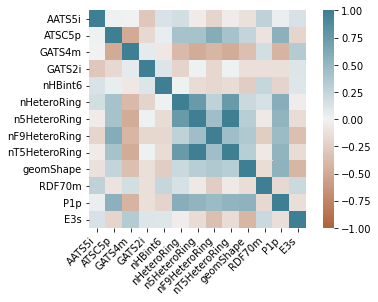

In [11]:
#investigation of correlation between the most important predictors

X_sub = pd.DataFrame(X_sub)
corr = X_sub.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(30, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
#only the most important features are pictured

In [12]:
#return the highest correlated features with the target class
#using the whole feature space

df_corr = df[df.columns[0:]].corr()['Activity'][:]
print("Correlations > 0.3: ", df_corr[df_corr > 0.15])
print("Correlations < -0.3: ", df_corr[df_corr < -0.15])

Correlations > 0.3:  Activity      1.000000
naAromAtom    0.172616
nAromBond     0.175687
nN            0.198808
nF            0.159884
                ...   
L1s           0.215845
P1s           0.207147
E1s           0.171923
Ts            0.200033
Ks            0.207537
Name: Activity, Length: 173, dtype: float64
Correlations < -0.3:  acvalue       -0.287592
ATSC1v        -0.159542
ATSC1p        -0.175812
ATSC1i        -0.171020
GATS3m        -0.159958
GATS4m        -0.185653
GATS4v        -0.163745
GATS2i        -0.157691
SM1_Dzv       -0.231287
SM1_Dzp       -0.217411
BCUTp-1h      -0.190902
nBondsD       -0.158530
nBondsD2      -0.158530
ASP-0         -0.179020
AVP-0         -0.180685
AVP-1         -0.161808
AVP-2         -0.159567
AVP-3         -0.152471
AVP-4         -0.154097
AVP-5         -0.158933
AVP-6         -0.167559
AVP-7         -0.166533
nHBint6       -0.163480
nHCsatu       -0.173596
SHCsatu       -0.165297
SssssC        -0.151203
minHCsatu     -0.170644
minaasC     

# ANN implementation

## Scaling, train and test split

**For the whole feature space**

In [13]:
#scaling the data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

#spliting the data into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, test_size=0.25, random_state=1)
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, 
                                                    y_train, test_size=0.3, random_state=1)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
y_train = y_train.astype(np.float)
y_test = y_test.astype(np.float)
X_train_val = X_train_val.astype(np.float)
X_test_val = X_test_val.astype(np.float)
y_train_val = y_train_val.astype(np.float)
y_test_val = y_test_val.astype(np.float)

y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
y_train_val = np.array(y_train_val).reshape(-1,1)
y_test_val = np.array(y_test_val).reshape(-1,1)

**For the LASSO-driven feature space reduction**

In [14]:
#scaling the data
scaler = StandardScaler()
scaler.fit(X_sub)
X_sub = scaler.transform(X_sub)

#spliting the data into train, test and validation sets
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, 
                                                    y_sub, test_size=0.25, random_state=1)
X_train_sub_val, X_test_sub_val, y_train_sub_val, y_test_sub_val = train_test_split(X_train_sub, 
                                                    y_train_sub, test_size=0.3, random_state=1)
X_train_sub = X_train_sub.astype(np.float)
X_test_sub = X_test_sub.astype(np.float)
y_train_sub = y_train_sub.astype(np.float)
y_test_sub = y_test_sub.astype(np.float)
X_train_sub_val = X_train_sub_val.astype(np.float)
X_test_sub_val = X_test_sub_val.astype(np.float)
y_train_sub_val = y_train_sub_val.astype(np.float)
y_test_sub_val = y_test_sub_val.astype(np.float)

y_train_sub = np.array(y_train_sub).reshape(-1,1)
y_test_sub = np.array(y_test_sub).reshape(-1,1)
y_train_sub_val = np.array(y_train_sub_val).reshape(-1,1)
y_test_sub_val = np.array(y_test_sub_val).reshape(-1,1)

## Parameters optimization

In [43]:
param_grid = {
    'n_hidden': [0, 1, 2, 3, 4],
    'learning_rate': [1, 0, 0.1, 0.01, 0.001, 0.0001],
    'dropout_rate': [1, 0, 0.01, 0.1, 1],
    'batch_size' : [128]#impossible to optimize the batch size
    }

grid = ParameterGrid(param_grid)
print(f"Parameter combinations in total: {len(grid)}")
#pprint(param_grid) 

Parameter combinations in total: 150


In [195]:
#complexity depends on the number of parameter combinations 
def build_model(num_features: int, 
                learning_rate: float,
                n_hidden: int,
                batch_size: int,
                dropout_rate: float):
    
    init_w = tf.keras.initializers.HeNormal()
    init_b = tf.keras.initializers.Constant(value=0.0)
    
    np.random.seed(0)
    

    model = Sequential()
    model.add(Dense(units=1_000, kernel_initializer=init_w, bias_initializer=init_b, input_shape=(num_features,)))
    model.add(Dropout(dropout_rate))
    model.add(Activation("elu"))
    for i in range(0, n_hidden):
        model.add(Dropout(dropout_rate))
        model.add(Dense(units=1_000-i*250, kernel_initializer=init_w, bias_initializer=init_b))
        model.add(Dropout(dropout_rate))
        model.add(Activation("elu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=num_targets, kernel_initializer=init_w, bias_initializer=init_b))
    model.add(Dropout(dropout_rate))
    model.add(Activation("sigmoid"))    
    # model.summary()
    
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=learning_rate),
        metrics=["accuracy"]
    )    
    
    return model

num_features = X_train.shape[1]
num_targets = 1 
epochs = 50

for idx, comb in enumerate(grid):
    

    results = {
        "best_score": -np.inf,
        "best_params": {},
        "val_scores": [],
        "params": []
    }
    

    model = build_model(
        num_features, 
        **comb)

    ANN = model.fit(
        X_train_val,
        y_train_val,
        epochs=epochs)
    
    #berechnet die Accuracy
    scores = model.evaluate(
        X_train_val,
        y_train_val,
        verbose=0)

    results["val_scores"].append(scores)
    results["params"].append(comb)
    #print(f"Accuracy = {scores}")
    print(f"Accuracy = {comb}")
    
    ypred = model.predict(X_test_val) 
    ypred = tf.math.round(ypred)
    print(f"Average precision score {average_precision_score(y_test_val, ypred):.3f}")

print(classification_report(y_test_val, ypred, digits=3))
print(confusion_matrix(y_test_val,ypred))
print(f"Average precision score {average_precision_score(y_test_val, ypred):.3f}")

Epoch 1/50


ValueError: ignored

## Best model

In [150]:
# Best parameters = {'batch_size': 128, 'dropout_rate': 0.0, 'learning_rate': 0.001, 'n_hidden': 3}

def build_model():
    
    #initializers for the weights and the bias
    init_w = tf.keras.initializers.HeNormal()
    init_b = tf.keras.initializers.Constant(value=0.0)
    
    #seed for reproducability
    np.random.seed(1)

    #create model
    model = Sequential()
    model.add(Dense(units=100, kernel_initializer=init_w, bias_initializer=init_b, input_shape=(num_features,)))#input layer
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=100, activation = "elu"))
    model.add(Activation("sigmoid"))    

    for i in range(0, n_hidden):#hidden layers (neurons: 25, 20, 15, 10, 5, ...)
        #model.add(Dropout(dropout_rate))
        model.add(Dense(units=100-i*25, kernel_initializer=init_w, bias_initializer=init_b))
        model.add(Dropout(dropout_rate))
        model.add(Activation("elu"))
        
    #model.add(Dropout(dropout_rate))
    model.add(Dense(units=num_targets, kernel_initializer=init_w, bias_initializer=init_b))#output layer
    #model.add(Dropout(dropout_rate))
    model.add(Activation("sigmoid"))    
    #model.summary()

    #compile model
    model.compile(
        loss="binary_crossentropy",
        optimizer='Adam',
        metrics=["accuracy"]
        )    
    
    return model

In [147]:
#initialize optimized parameters
epochs = 200
batch_size = 128
learning_rate = 0.001
n_hidden = 3
dropout_rate = 0.1

**For the whole feature space**

In [ ]:
num_features = X_train.shape[1]
num_targets = y_train.shape[1] 

pd.DataFrame(X_train)
pd.DataFrame(y_train)

np.random.seed(1)
model = build_model()
model_ANN = model.fit(X_train, y_train, validation_data=(X_test_val, y_test_val), batch_size = batch_size, epochs = epochs)
scores = model.evaluate(X_train, y_train, verbose=1)

np.random.seed(1)
ypred = model.predict(X_test)
ypred = tf.math.round(ypred)

              precision    recall  f1-score   support

         0.0      0.545     0.600     0.571        30
         1.0      0.700     0.651     0.675        43

    accuracy                          0.630        73
   macro avg      0.623     0.626     0.623        73
weighted avg      0.636     0.630     0.632        73

Average precision score: 0.661
Train accuracy: 0.982, Validation accuracy: 0.993, Test accuracy: 0.630
Cohen kappa score:  0.24742268041237125
Confusion matrix: 
[[18 12]
 [15 28]]


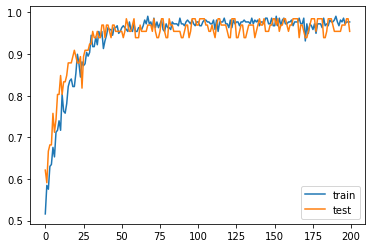

In [152]:
np.random.seed(1)
print(classification_report(y_test, ypred, digits=3))
print(f"Average precision score: {average_precision_score(y_test, ypred):.3f}")
loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
loss, val_acc = model.evaluate(X_train_val, y_train_val, verbose=0)
loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Train accuracy: %.3f, Validation accuracy: %.3f, Test accuracy: %.3f' % (train_acc, val_acc, test_acc))


print("Cohen kappa score: ", cohen_kappa_score(y_test, ypred))

print("Confusion matrix: ")
print(confusion_matrix(y_test, ypred))

#precision = fraction of true(+) correctly classified as (+) among all examples
#recall = sensitivity = fraction of correctly predicted examples among the examples of that class
#The Kappa statistic is describing how well the classifier performs above that baseline level of performance, indeed showing that they are better than random chance predictions.

# learning curves of model accuracy
plt.plot(model_ANN.history['accuracy'], label='train')
plt.plot(model_ANN.history['val_accuracy'], label='test')
plt.legend()
plt.show()

#f1-score = mean of the precision and recall (better to use that compared to accuracy when the data is unevenly distributed)

Kappa Agreement
< 0 Less than chance agreement
0.01–0.20 Slight agreement
0.21– 0.40 Fair agreement
0.41–0.60 Moderate agreement
0.61–0.80 Substantial agreement
0.81–0.99 Almost perfect agreement

**For the LASSO-driven feature space reduction**

In [ ]:
num_features = X_train_sub.shape[1]
num_targets = y_train_sub.shape[1] 

pd.DataFrame(X_train_sub)
pd.DataFrame(y_train_sub)

np.random.seed(1)
model_sub = build_model()
model_ANN_sub = model_sub.fit(X_train_sub, y_train_sub, validation_data=(X_test_sub_val, y_test_sub_val), batch_size = batch_size, epochs = epochs)
scores = model_sub.evaluate(X_train_sub, y_train_sub, verbose=1)

np.random.seed(1)
ypred_sub = model_sub.predict(X_test_sub)
ypred_sub = tf.math.round(ypred_sub)

              precision    recall  f1-score   support

         0.0      0.481     0.433     0.456        30
         1.0      0.630     0.674     0.652        43

    accuracy                          0.575        73
   macro avg      0.556     0.554     0.554        73
weighted avg      0.569     0.575     0.571        73

Average precision score: 0.617
Train accuracy: 0.982, Test accuracy: 0.575
Cohen kappa score:  0.10940574576938211
Confusion matrix: 
[[13 17]
 [14 29]]


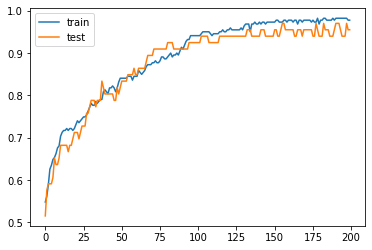

In [109]:
np.random.seed(1)
print(classification_report(y_test_sub, ypred_sub, digits=3))
print(f"Average precision score: {average_precision_score(y_test_sub, ypred_sub):.3f}")
loss, train_acc = model_sub.evaluate(X_train_sub, y_train_sub, verbose=0)
loss, test_acc = model_sub.evaluate(X_test_sub, y_test_sub, verbose=0)
print(f'Train accuracy: %.3f, Test accuracy: %.3f' % (train_acc, test_acc))


print("Cohen kappa score: ", cohen_kappa_score(y_test_sub, ypred_sub))

print("Confusion matrix: ")
print(confusion_matrix(y_test_sub, ypred_sub))

#precision = fraction of true(+) correctly classified as (+) among all examples
#recall = sensitivity = fraction of correctly predicted examples among the examples of that class
#The Kappa statistic is describing how well the classifier performs above that baseline level of performance, indeed showing that they are better than random chance predictions.

# learning curves of model accuracy
plt.plot(model_ANN_sub.history['accuracy'], label='train')
plt.plot(model_ANN_sub.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## ROC curves of best model

#### **For the whole feature space**

>>
Fold = 0
Epoch 1/50
2/2 [==============================] - 1s 11ms/step - loss: 0.8486 - accuracy: 0.4977
Epoch 2/50
2/2 [==============================] - 0s 10ms/step - loss: 0.7334 - accuracy: 0.5936
Epoch 3/50
2/2 [==============================] - 0s 10ms/step - loss: 0.5938 - accuracy: 0.6621
Epoch 4/50
2/2 [==============================] - 0s 10ms/step - loss: 0.5702 - accuracy: 0.6895
Epoch 5/50
2/2 [==============================] - 0s 11ms/step - loss: 0.5425 - accuracy: 0.7260
Epoch 6/50
2/2 [==============================] - 0s 13ms/step - loss: 0.5058 - accuracy: 0.7626
Epoch 7/50
2/2 [==============================] - 0s 10ms/step - loss: 0.4802 - accuracy: 0.7717
Epoch 8/50
2/2 [==============================] - 0s 11ms/step - loss: 0.4581 - accuracy: 0.8174
Epoch 9/50
2/2 [==============================] - 0s 10ms/step - loss: 0.4404 - accuracy: 0.8174
Epoch 10/50
2/2 [==============================] - 0s 9ms/step - loss: 0.4184 - accuracy: 0.8311
Epoch 11/50
2/2 [=

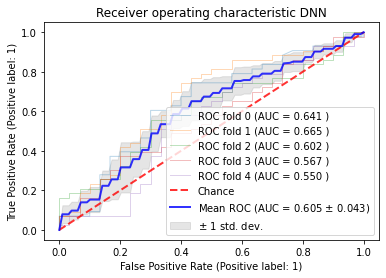

In [115]:
## ROC Curve 

from sklearn.metrics import plot_roc_curve, roc_curve, auc, roc_auc_score

init_w = tf.keras.initializers.HeNormal()
init_b = tf.keras.initializers.Constant(value=0.0)
num_features = X_train.shape[1]
num_targets = y_train.shape[1]
learning_rate = 0.001
n_hidden = 3
batch_size = 128
epochs = 50
dropout_rate = 0.0
no_splits = 5

cv = StratifiedKFold(n_splits=no_splits)
results = np.zeros_like(y_train, dtype=np.float32)


prbs = []
tprs = []
fprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


fig, ax = plt.subplots()
    
j = 0
for train_val_idx, test_val_idx in cv.split(X_train_val, y_train_val):
    while j < no_splits: 
        print(">>")
        print(f"Fold = {j}")

        model = build_model()
        model_ANN = model.fit(X_train, y_train, batch_size=batch_size, epochs = epochs, verbose = 1)

        probas_ = model.predict(X_test)
        prbs.append(probas_)
        fpr, tpr, thresholds = roc_curve(y_test, probas_[ :])

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        auc_ = auc(fpr, tpr)
        aucs.append(auc_)

        plt.plot(fpr, tpr,
            label=r'ROC fold %i (AUC = %0.3f )' % (j, auc_),
            lw=1, alpha=.3)        
        j += 1

# Average the predictions        
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc =np.std(aucs)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)


std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic DNN")
ax.set_xlabel('False Positive Rate (Positive label: 1)')
ax.set_ylabel('True Positive Rate (Positive label: 1)')

ax.legend(loc="lower right")

plt.savefig("ann.pdf", dpi=600,transparent=True)
plt.savefig("ann.jpg", dpi=600,transparent=True)
plt.show()

#### **For the LASSO-driven feature space reduction**

In [ ]:
## ROC Curve 

from sklearn.metrics import plot_roc_curve, roc_curve, auc, roc_auc_score

init_w = tf.keras.initializers.HeNormal()
init_b = tf.keras.initializers.Constant(value=0.0)
num_features = X_train_sub.shape[1]
num_targets = y_train_sub.shape[1]
learning_rate = 0.001
n_hidden = 3
batch_size = 128
epochs = 50
dropout_rate = 0.0
no_splits = 5

cv = StratifiedKFold(n_splits=no_splits)
results = np.zeros_like(y_train_sub, dtype=np.float32)


prbs = []
tprs = []
fprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


fig, ax = plt.subplots()
    
j = 0
for train_val_idx, test_val_idx in cv.split(X_train_sub_val, y_train_sub_val):
    while j < no_splits: 
        print(">>")
        print(f"Fold = {j}")
        
        model = build_model()
        model_ANN_sub = model.fit(X_train_sub, y_train_sub, epochs=epochs, 
                  batch_size=batch_size, verbose=1)

        probas_ = model.predict(X_test_sub)
        prbs.append(probas_)
        fpr, tpr, thresholds = roc_curve(y_test, probas_[ :])

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        auc_ = auc(fpr, tpr)
        aucs.append(auc_)

        plt.plot(fpr, tpr,
            label=r'ROC fold %i (AUC = %0.3f )' % (j, auc_),
            lw=1, alpha=.3)        
        j += 1

# Average the predictions        
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc =np.std(aucs)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)


std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic DNN")
ax.set_xlabel('False Positive Rate (Positive label: 1)')
ax.set_ylabel('True Positive Rate (Positive label: 1)')

ax.legend(loc="lower right")

plt.savefig("ann.pdf", dpi=600,transparent=True)
plt.savefig("ann.jpg", dpi=600,transparent=True)
plt.show()

Intepreting ROC curves: https://www.datascienceblog.net/post/machine-learning/interpreting-roc-curves-auc/#:~:text=%20Interpreting%20ROC%20Curves%2C%20Precision-Recall%20Curves%2C%20and%20AUCs,to%20learn%20more%20about%20the%20differences...%20More%20